# Meta-Level Features
Meta-level features in text classification are feature vectors for machine learning models that do not contain actual word representations, but properties of the words and sentences (in this case tweets). In this notebook, we will look at different types of meta-level features: Tweet Statisitcs, Lingustic Tags, Named Entities, Acronyms & Emojis, Word Emphasis & Punctuation and finally Sentiment Scores. In a final summary, we will evaluate and rank the perofrmance of the presented meta-level features and compare them to a Bag-of-Words approach.

In [3]:
!pip install textblob vaderSentiment afinn
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7 MB 6.7 MB/s eta 0:00:017    |█████████████████▉              | 436.8 MB 7.6 MB/s eta 0:00:46     |███████████████████████████▍    | 669.4 MB 5.9 MB/s eta 0:00:20
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
# Run some NB preprocessing used throughout the rest of the sections

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_extraction, feature_selection
from features import meta_features_spacy as mf

# The training data file
train_data_file = '../data/external/kaggle/train.csv'
# Load data and perform some sanity checks
print('Loading training data from {}...'.format(train_data_file))
df = pd.read_csv(train_data_file)
X = df[['keyword', 'location', 'text']].values
y = df['target'].values
print('-> Done')

# Perform basic preprocessing of the data and convert to a spacy featuer set
sp = spacy.load('en_core_web_lg')
def preproc(x):
    #txt = " ".join([str(x[i]) for i in range(0, 3) if str(x[i]) != "nan"])
    #return sp(txt)
    return sp(x[2])
print("Converting tweets to spacy docs...")
X_sp = np.array([preproc(x) for x in X], dtype=object)
print("-> Done.")

Loading training data from ../data/external/kaggle/train.csv...
-> Done
Converting tweets to spacy docs...
-> Done.


# Features based on Tweet Statistics
Here we analyze features based on tweet satistics like length of a tweet, the number of links therein 

## Links
Some notebooks in the competition and research papers remove links in the preprocessing step. However, it might be worth indicating if a tweet contains a link or not. The intuition behind that is that people also use links to back things up.

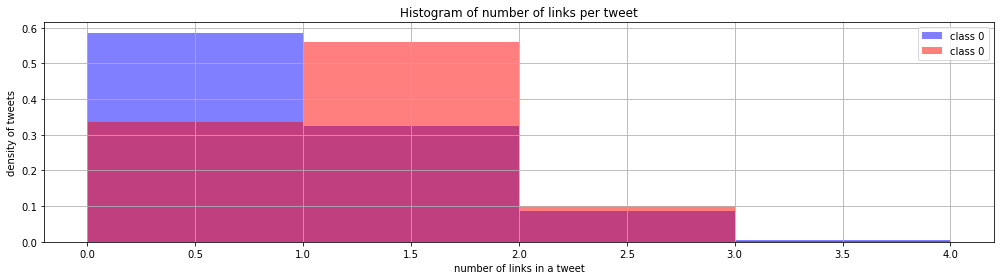

In [5]:
trans = mf.LinkCounter()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()

# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of number of links per tweet')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 0', alpha=0.5)
plt.xlabel('number of links in a tweet')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()


The histogram indicates that tweets that are not about real disasters tend to mostly not containing a link. However, tweets about real disasters seem to have a higher probability of containing exactly one link.

## Tweet Length
Does the length of a tweet contain differentiating information about its disasterous nature? The length of a tweet is here interpreted as the number of characters in the tweet.

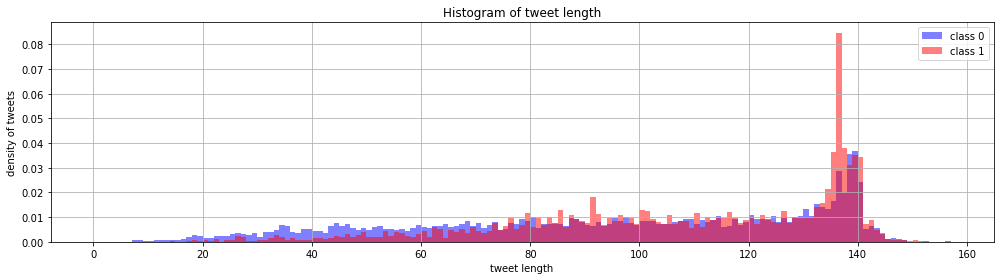

In [6]:
# Count number of links in each tweet
trans = mf.TextLength()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()

# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of tweet length')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('tweet length')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()

We might also interpret a tweet length as the number of tokens:

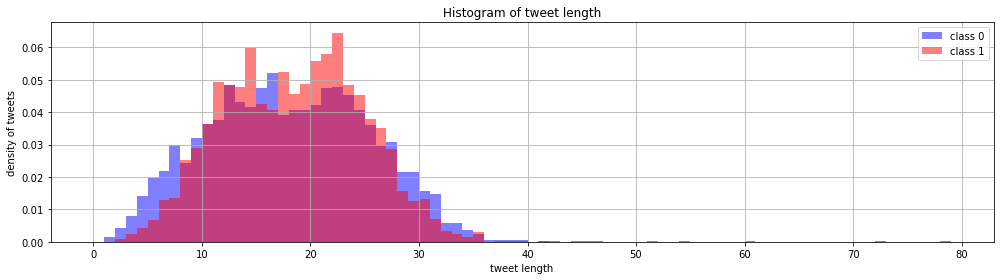

In [7]:
# Count number of links in each tweet
trans = mf.TextLength(mode='tokens')
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()

# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of tweet length')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('tweet length')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()

The histograms reveal that tweets about real disaster tend to be in the range of about 130 to 175 characters and 15 to 13 tokens.

# Features based on Linguistic Tags
Features based on linguistic properties that we will analyze in the following consist of annotations for part-of-speech, syntacic dependencies and named entities. The sklearn transformers vectorize them as term TF-IDF matrices with a tag for each dimension.

In [8]:
# Bar plot function to visualise the tag distributions
def plot_count_vec_bars(X_sp, transformer, title, exclude=[]):  
    transformer.fit(X_sp)
    labels = transformer.get_feature_names()
    
    # Compute counts
    count = transformer.transform(X_sp).toarray()
    # Remove blacklisted tags from column
    for exc_tag in exclude:
        del_idx = labels.index(exc_tag.lower())
        labels = np.delete(labels, del_idx)
        count = np.delete(count, del_idx, 1)
        
    # Compute support: how many of the tweets have non zero rows out of all tweets
    support = np.sum(np.sum(count, axis=1) > 0) / float(len(y))

    # Split counts into classes
    count_c0 = count[y==0]
    count_c1 = count[y==1]
    s0 = count_c0.sum(axis=0)
    s1 = count_c1.sum(axis=0)
    # Plot class 0 bars
    plt.figure(figsize=(14, 6))

    # Sort by class 0 counts
    sorted_idx = np.argsort(s0)[::-1]
    s0 = s0[sorted_idx]
    s1 = s1[sorted_idx]
    labels = np.array(labels)[sorted_idx]

    plt.title('{} (Support: {}%)'.format(title, round(support*100, 1)))
    plt.bar(np.arange(len(labels)), s0/float(s0.sum()), fc=(0, 0, 1, 0.5), label="Class 0")
    plt.bar(np.arange(len(labels)), s1/float(s1.sum()), fc=(1, 0, 0, 0.5), label="Class 1")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.legend()
    plt.xlabel("Tag")

    plt.tight_layout()
    plt.show()

## Part-of-speech Tags
In this section we will look at the distribution of POS tags in a tweet. The distribution might give hints to what tags occur often in one class, but not the other. We will use two sets of tags: The universal tags and an english-specific Penn Treebank tagset.

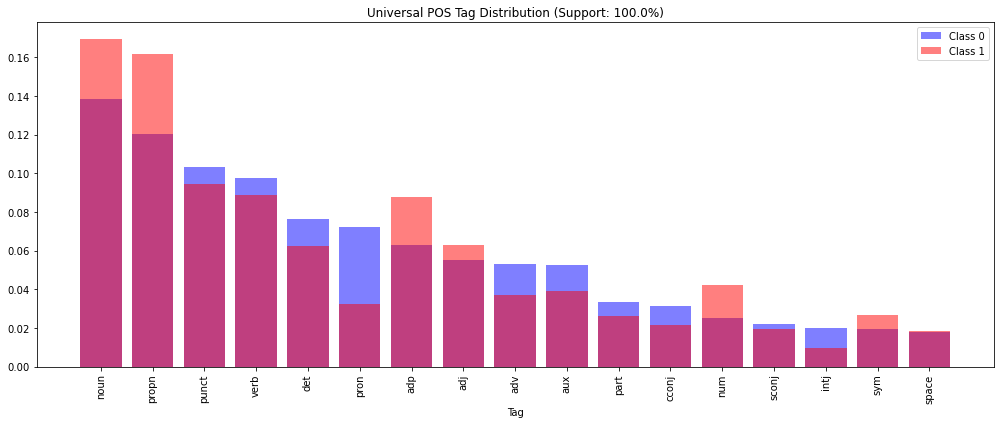

In [9]:
plot_count_vec_bars(X_sp, mf.PosTagCountVectorizer('universal'), 'Universal POS Tag Distribution')

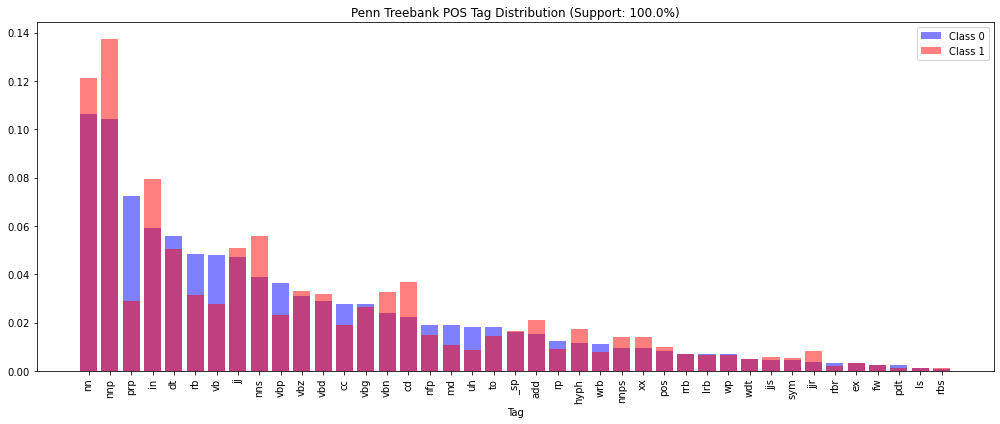

In [10]:
plot_count_vec_bars(X_sp, mf.PosTagCountVectorizer('penn_treebank'), 'Penn Treebank POS Tag Distribution')

Explenation for the tags with highest difference:

In [11]:
for tag in ['propn', 'noun', 'pron', 'adp', 'nnp', 'prp', 'in']:
    print('* {}: {}'.format(tag, spacy.explain(tag.upper())))

* propn: proper noun
* noun: noun
* pron: pronoun
* adp: adposition
* nnp: noun, proper singular
* prp: pronoun, personal
* in: conjunction, subordinating or preposition


The biggest differences between classes seem to occur for nouns (overrepresented in class 1) and personal pronouns.

## Syntacic Dependency Tags
Similar to the POS tags in a tweet, we can check the syntacic dependencies. The distribution might give hints to what dependencies occur often in one class, but not the other.

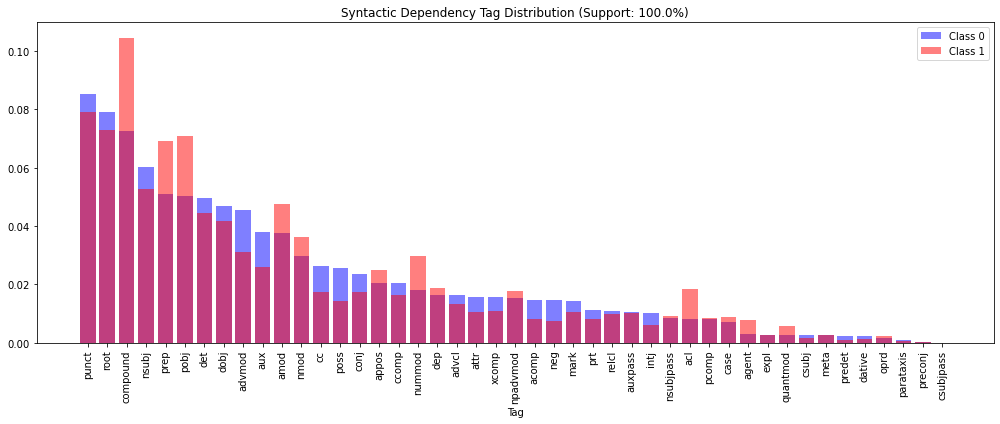

In [12]:
plot_count_vec_bars(X_sp, mf.DependencyTagCountVectorizer(), 'Syntactic Dependency Tag Distribution')

Explenation for the tags with highest difference:

In [13]:
for tag in ['compound', 'prep', 'pobj', 'advmod', 'aux', 'poss']:
    print('* {}: {}'.format(tag, spacy.explain(tag)))

* compound: compound
* prep: prepositional modifier
* pobj: object of preposition
* advmod: adverbial modifier
* aux: auxiliary
* poss: possession modifier


It seems that generally only class 1 seem to have clear differences for certain dependency tags. These are compound and preposition tags.

# Named Entities
While the previous tags where assigned to each token, named entities are processed by sentences / documents. We can extract two types of meta-level features from named entities: Either the number of named entities within a tweet or the concrete types of the named entities in the tweet. We first start of with the number of entities: 

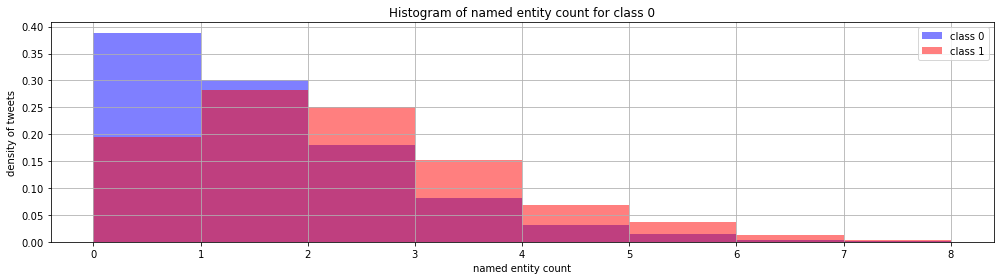

In [14]:
trans = mf.NumNamedEntities()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()
    
# Plot class-specific histograms of named entity counts
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of named entity count for class 0')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('named entity count')
plt.ylabel('density of tweets')
plt.grid(True)
plt.legend()
# Show final plots
plt.tight_layout()
plt.show()

The barplot shows that tweets that are not about real disasters tend to have less named entities ocurrences than tweets about real disasters. So lets see if there is a preference in entity types:

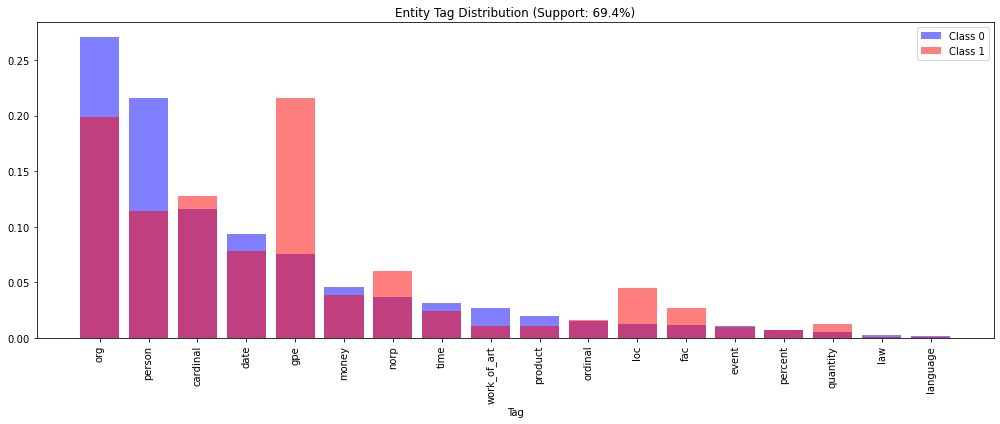

In [15]:
plot_count_vec_bars(X_sp, mf.EntityTagCountVectorizer(), 'Entity Tag Distribution')

The plot indicates that tweets that are not about real disasters tend to mention people as well as companies, agencies, institutions, etc. more. Tweets about real disasters on the other hand tend to mention countries, cities, states more as well as nationalities or religious or political groups. In fact, they seem to reference locations more. Fortunately, the entity typ seems to have a high support in the data and is therefore usable for the majority of the tweets.

# Acronyms & Emojis
Meta-Level features that target emotions are often used in sentiment identification problems. However, one can imagine that tweets about real disasters might involve emotions and some emojis or acronyms like `:-)`, `lol`, `=D` do not occur in such tweets. The following transformers tag the tweets with common social media acronyms and emotions.

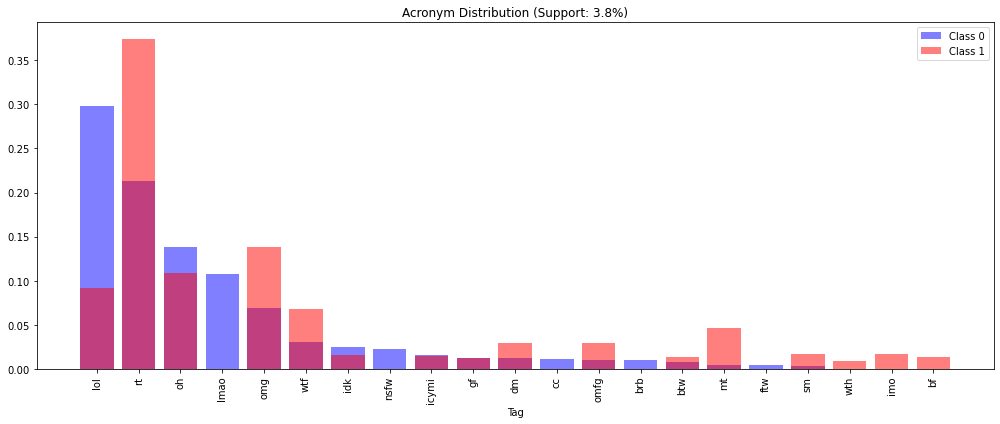

In [16]:
acro_vectorizer = mf.AcronymCountVectorizer()
plot_count_vec_bars(X_sp, acro_vectorizer, 'Acronym Distribution', exclude=['NO_ACRONYM'])

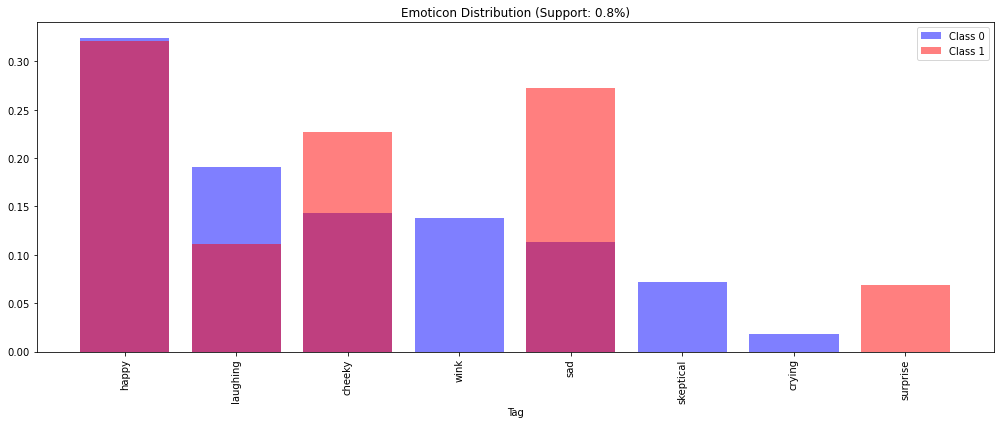

In [17]:
emoji_vectorizer = mf.EmojiCountVectorizer()
plot_count_vec_bars(X_sp, emoji_vectorizer, 'Emoticon Distribution', exclude=['NO_EMOTICON'])

First thing to note is that the support of both feautres is very low. The acronyms can be used in around 4% of the tweets, while the emoticons in less than 1%. The acronyms shows a plausible distribution (e.g. `lol` and `lmao` is heavily overrepresented in tweets that are not about real disasters, while `rt` and `omg` tend to occurre more ni tweets about real disasters). However, while we expect that `sad` emoticons occurre in tweets about real disasters, the distribution of emoticons seems not plausible in other important parts: E.g. the `happy` and `cheeky` emojis are on par in tweets about real and not real disasters.

Lets see the tweets that are off:

In [18]:
import numpy as np

# There are some tweets in which lol is in a ztweet about real disasters? Lets check them out:
emo_tags = np.array([" ".join([emoji_vectorizer.find_emo_tag(token) for token in tweet]) for tweet in X_sp])
acro_tags = np.array([" ".join([acro_vectorizer.find_acro_tag(token) for token in tweet]) for tweet in X_sp])
for tweet, c, emo, acro in zip(X_sp, y, emo_tags, acro_tags):
    if c == 1 and "LOL" in acro:
        print('---')
        print('[{}] {} [class {}]'.format("LOL", tweet, c))
    if c == 1 and "BF" in acro:
        print('---')
        print('[{}] {} [class {}]'.format("BF", tweet, c))
    if c == 1 and "HAPPY" in emo:
        print('---')
        print('[{}] {} [class {}]'.format("HAPPY", tweet, c))
    if c == 1 and "CHEEKY" in emo:
        print('---')
        print('[{}] {} [class {}]'.format("CHEEKY", tweet, c))

---
[CHEEKY] #PBBan (Temporary:300) hyider_ghost2 @'aRmageddon | DO NOT KILL | FLAGS ONLY | Fast XP' for Reason [class 1]
---
[HAPPY] CDC has a pretty cool list of all bioterrorism agents :3 [class 1]
---
[HAPPY] @Ashayo @MsMiggi Hi Ashayo! I believe there will be VODs on YouTube after the presentation but there is nothing like seeing it live :) [class 1]
---
[BF] '@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ?? [class 1]
---
[LOL] @HighQualityBird a reverse situation (lol I don't know 9/11?) where US civilian deaths were specifically utilized to make a political [class 1]
---
[HAPPY] @Raishimi33 :) well I think that sounds like a fine plan where little derailment is possible so I applaud you :) [class 1]
---
[CHEEKY] @KlaraJoelsson Well I have seen it now! That's a bummer. We've had this heat wave tho... 43'c!! I'd prefer the rain... :P [class 1]
---
[LOL] @Cali74142290 lol natural disaster/hospital crisis something is needed to get rid of some cast members.... [class 1]
---
[LOL] MR

# Emphasis & Punctuations
Another set of Meta-Level features that are similar to emoticons and acronyms are punctuations (`!`, `?`, `:`) and word emphasis like elongation (`wreeeecked`) and capitalization (`CRUSHED`). We expect elongated words to decrease seriousness of a tweet and occurrences of capitalized words to occurre in tweets about outraged and shocked events. The following transformers tag the tweets with word emphasis:

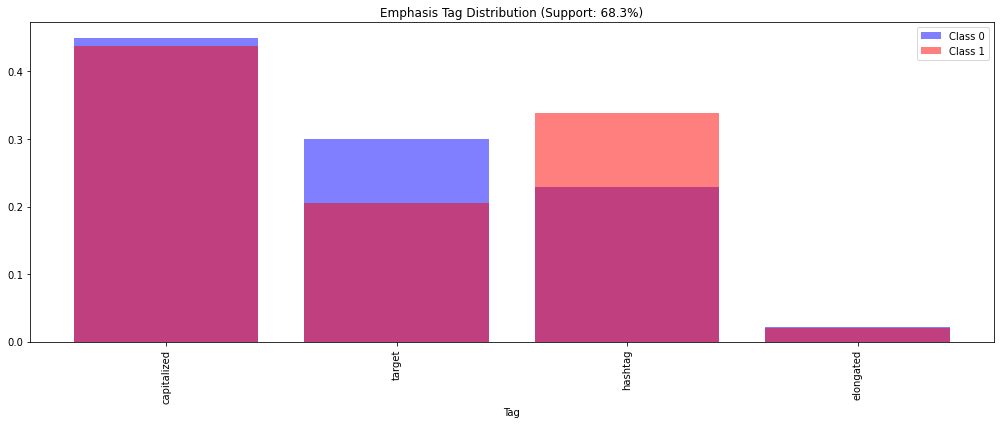

In [19]:
plot_count_vec_bars(X_sp, mf.EmphasisCountVectorizer(), 'Emphasis Tag Distribution', exclude=['NOT_EMPHASIZED'])

Well, it turns out that my expectations were completely off. However, hashtags tend to occurre more in tweets about disasters in contrast to tweets that contain user mentions (i.e. targets). Lets examine if punctuations are overrepresented in one of the classes:

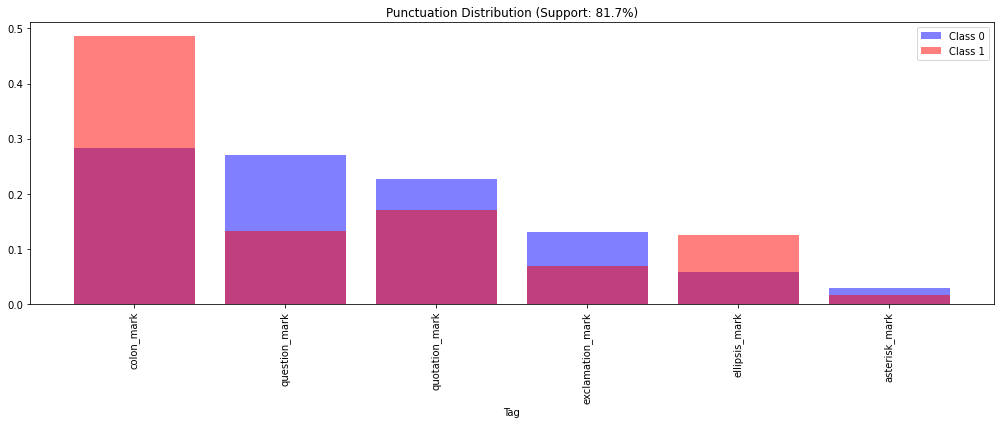

In [20]:
plot_count_vec_bars(X_sp, mf.PunctuationCountVectorizer(), 'Punctuation Distribution', exclude=['NO_PUNCTUATATION'])

Surprisingly, exclamation marks do not seem to be overrepresented in tweets about real disasters. However, question marks occurre more often in tweets that are not about disasters, while colons occurre more in tweets about real disasters.

# Sentiment Analysis
We expect that tweets about real disaster tend to be associated with more negative emotions or at least without positive ones. Hence, sentiment scores for a tweet might be a useful feature for discrimination between tweets about real disasters and not. In this section we evaluate three dictionary-based sentiment analyzers, namely the TextBlob, Vader and Afinn models.

## TextBlob Model
The default TextBlob sentiment analyzer is based on a pattern analyzer to compute polarity scores for sentences. Details can be found https://textblob.readthedocs.io/en/dev/advanced_usage.html#sentiment-analyzers.

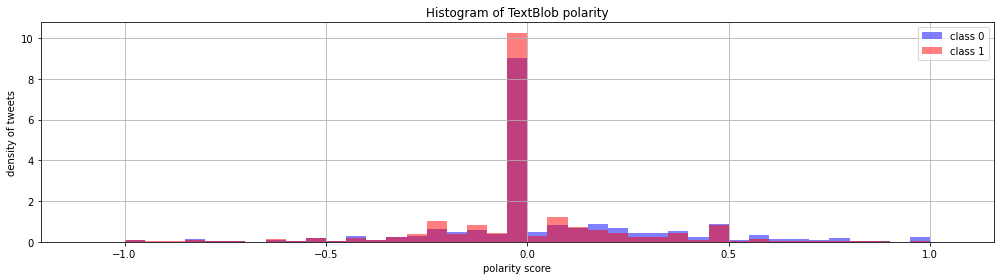

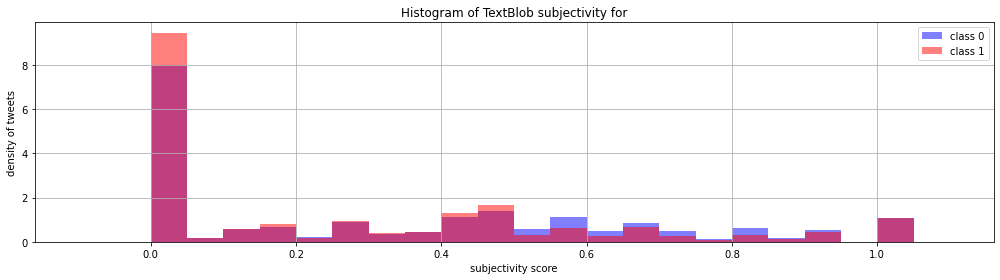

In [21]:
# https://textblob.readthedocs.io/en/dev/advanced_usage.html#sentiment-analyzers

transformer = mf.TextBlobSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)

pol_c0 = X_trans[y==0, 0]
pol_c1 = X_trans[y==1, 0]
subj_c0 = X_trans[y==0, 1]
subj_c1 = X_trans[y==1, 1]

# Plot class specific histogram of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-1.1, 1.1, 0.05)
plt.title('Histogram of TextBlob polarity')
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
#plt.ylim([0, 1.5])
plt.grid(True)
plt.tight_layout()
plt.legend()

# Plot class specific histogram of subjectivity
plt.figure(figsize=(14, 4))
bins = np.arange(-0.1, 1.1, 0.05) 
plt.title('Histogram of TextBlob subjectivity')
n, _, _ = plt.hist(subj_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(subj_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('subjectivity score')
plt.ylabel('density of tweets')
#plt.ylim([0, 2.0])
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

The distribution shows a very slight bias of tweets that are not about real disaster towards positive and subjective scores. However, a score of 0 domiantes the distribution heavily suggesting that the majority of tweets were not scorable. The TextBlob analyzer also supports a pre-trained Naive Bayes classifier that was trained on movie reviews. In this case, the distribution looks as follows:

In [22]:
# TODO

## Valence Aware Dictionary for sEntiment Reasoning Vader (VADER)
The VADER sentiment analyzer is a popular dictionary-based model that was tuned towards social media. Therefore, we can expect VADER to perform better than other sentiment analyzers that do not take the language used in social media into account. However, keep in mind that twitter developed an even more specific language used in tweets (due to maximum characters and other constraints). Details can be found at https://github.com/cjhutto/vaderSentiment. The distributions for the different scores the VADER analyzer outputs can be found in the following:

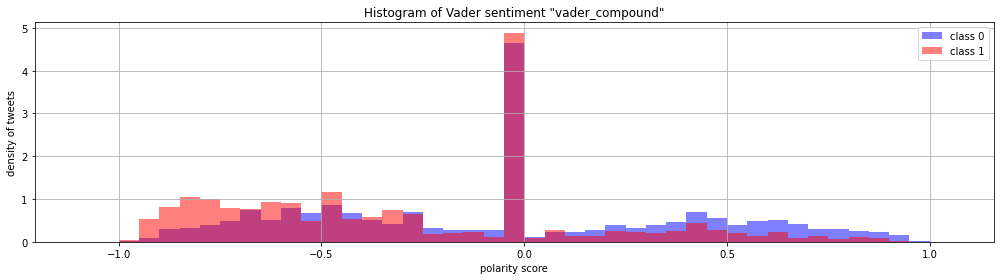

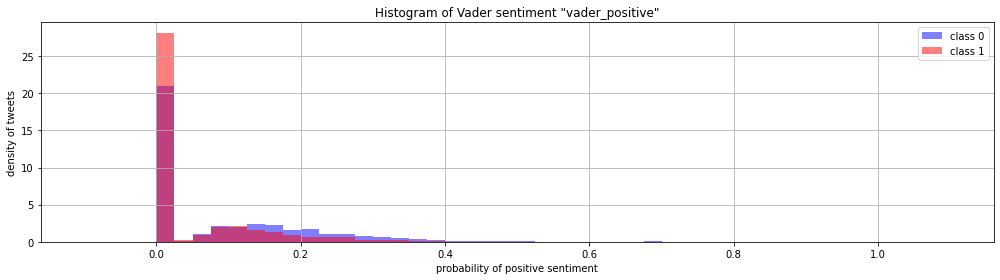

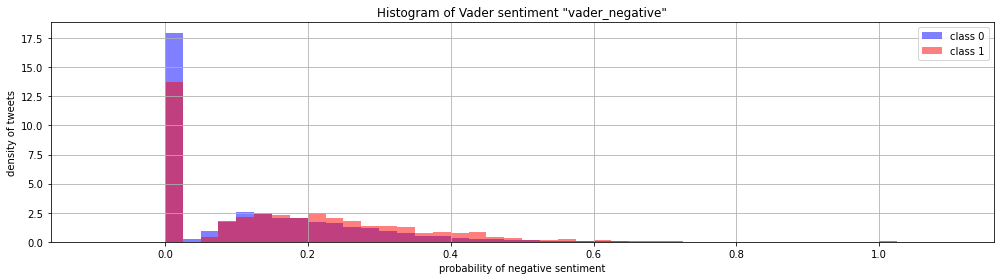

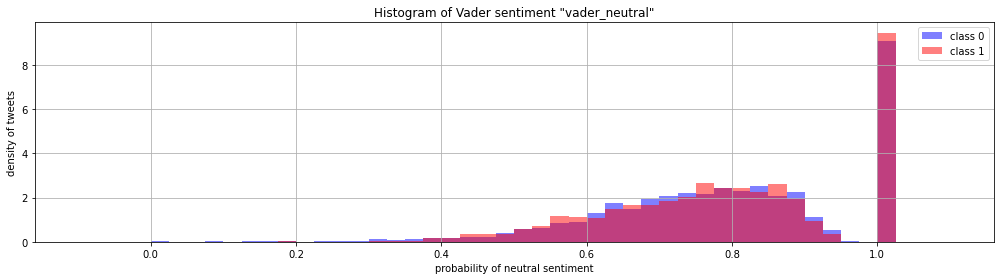

In [23]:
# Compute sentiments
transformer = mf.VaderSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)
labels = transformer.get_feature_names()

# Plot class specific histograms of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-1.1, 1.1, 0.05)
pol_c0 = X_trans[y==0, 0]
pol_c1 = X_trans[y==1, 0]
# Plot historgram for class 0
plt.title('Histogram of Vader sentiment "{}"'.format(labels[0]))
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
#plt.ylim([0, 1.5])
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot class specific histograms of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-0.1, 1.1, 0.025)
pol_c0 = X_trans[y==0, 1]
pol_c1 = X_trans[y==1, 1]
# Plot historgram for class 0
plt.title('Histogram of Vader sentiment "{}"'.format(labels[1]))
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('probability of positive sentiment')
plt.ylabel('density of tweets')
#plt.ylim([0, 2.5])
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot class specific histograms of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-0.1, 1.1, 0.025)
pol_c0 = X_trans[y==0, 2]
pol_c1 = X_trans[y==1, 2]
# Plot historgram for class 0
plt.title('Histogram of Vader sentiment "{}"'.format(labels[2]))
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('probability of negative sentiment')
plt.ylabel('density of tweets')
#plt.ylim([0, 2.5])
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot class specific histograms of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-0.1, 1.1, 0.025)
pol_c0 = X_trans[y==0, 3]
pol_c1 = X_trans[y==1, 3]
# Plot historgram for class 0
plt.title('Histogram of Vader sentiment "{}"'.format(labels[3]))
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('probability of neutral sentiment')
plt.ylabel('density of tweets')
#plt.ylim([0, 3.0])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


The compound score distribution looks a lot more promising than the results from the TextBlob Analyzer. While we have a predominant peek at a 0 score in all components, we can see that the distributions for the compound score, positive as well as negative probablity show the expected biases. Tweets about real disasters tend to be classified into the negative sentiment range and tweets that are not about real disasters more into the positive sentiment range.

## AFINN Model
The AFINN sentiment analyzer is refines the dictionary based approach to microblogs, especially to twitter. One would expect AFINN to perform better than the previous analyzers as its corpus is based on actual tweets. However, they state in their linked paper that the used approach is less elaborate than other models. Details can be found at https://github.com/fnielsen/afinn. The distributions for the score that the AFINN analyzer outputs can be found in the following:

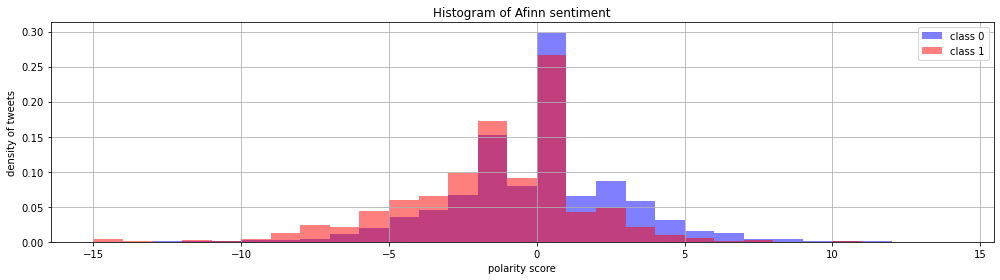

In [24]:
# Compute sentiments
transformer = mf.AfinnSentimentVectorizer()
X_trans = transformer.fit_transform(X_sp)
labels = transformer.get_feature_names()

# Plot class specific histograms of polarity
plt.figure(figsize=(14, 4))
bins = np.arange(-15, 15, 1)
pol_c0 = X_trans[y==0, 0]
pol_c1 = X_trans[y==1, 0]
# Plot historgram for class 0
plt.title('Histogram of Afinn sentiment')
n, _, _ = plt.hist(pol_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(pol_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('polarity score')
plt.ylabel('density of tweets')
#plt.ylim([0, 1.5])
plt.grid(True)
plt.legend()
plt.tight_layout()

While most tweets still get a zero score, the peak is much lower compared to the other models. We can also see the expected bias here for negative sentiment in tweets about real disasters and positive sentiment in tweets that are not about real disasters.

# Summary
In this section, we will compare the different meta-level features to each other in order to estimate which ones might be the most useful ones for classifying if a tweet is about real disasters or not.

In [25]:
# Intitialize full list of transformers to use in summary
transformers = {
    "link-count": mf.LinkCounter(),
    "tweet-length-char": mf.TextLength(mode='characters'),
    "tweet-length-token": mf.TextLength(mode='tokens'),
    "number-named-entities": mf.NumNamedEntities(),
    "entity-type-frequencies": mf.EntityTagCountVectorizer(),
    "univeral-pos-frequencies": mf.PosTagCountVectorizer(pos_type='universal'),
    "penn-tree-pos-frequencies": mf.PosTagCountVectorizer(pos_type='penn_treebank'),
    "dependency-frequencies": mf.DependencyTagCountVectorizer(),
    "emphasis-frequencies": mf.EmphasisCountVectorizer(),
    "punctuation-frequencies": mf.PunctuationCountVectorizer(),
    "emoji-frequencies": mf.EmojiCountVectorizer(),
    "acronym-frequencies": mf.AcronymCountVectorizer(),
    "textblob-sentiment": mf.TextBlobSentimentVectorizer(),
    "vader-sentiment": mf.VaderSentimentVectorizer(),
    "afinn-sentiment": mf.AfinnSentimentVectorizer()
}

## Performance from Chance
one method to assess how the individual meat-level features perform is to compare how much they increase performance under the same classifier from chance metrics. Chance metrics are the scores that a classifier would get if it predicts a label randomly.

In [26]:
from sklearn import metrics

# Compute chance performance metrics
y_pred_chance = np.random.randint(0, 2, size=len(y))
f1_chance = metrics.f1_score(y, y_pred_chance)
prec_chance = metrics.precision_score(y, y_pred_chance)
recall_chance = metrics.recall_score(y, y_pred_chance)

print(metrics.classification_report(y, y_pred_chance))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54      4342
           1       0.44      0.51      0.47      3271

    accuracy                           0.51      7613
   macro avg       0.51      0.51      0.50      7613
weighted avg       0.52      0.51      0.51      7613



In [27]:
from sklearn import svm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
import evaluation

print('Evaluating meta features...')
performance_res = {}
for label in transformers:
    # Setup linear classifier
    model_base = Pipeline([
        ('transformer', transformers[label]),
        ('scaler', preprocessing.MaxAbsScaler()),
        ('clf', svm.LinearSVC(C=1, class_weight='balanced', random_state=42))
    ])
    # Run evaluation
    _, _, test_res = evaluation.evaluate(model_base, store_model=False, store_submission=False, preprocessing_func=preproc, n_folds=10)
    # Compute performance results
    test_f1 = metrics.f1_score(test_res['y_true'], test_res['y_pred'])
    test_precision = metrics.precision_score(test_res['y_true'], test_res['y_pred'])
    test_recall = metrics.recall_score(test_res['y_true'], test_res['y_pred'])
    test_accuracy = metrics.accuracy_score(test_res['y_true'], test_res['y_pred'])
    feature_names = model_base['transformer'].get_feature_names()
    performance_res[label] = {
        'F1': test_f1,
        'Precision': test_precision,
        'Recall': test_recall,
        'Accuracy': test_accuracy,
        'features': feature_names, 
    }

INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...


Evaluating meta features...


/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([preprocessing_func(x) for x in X])
INFO:root:-> Feature matrix after preprocessing: (7613,)
INFO:root:Evaluating model with 1 experiment(s) of 10-fold Cross Validation...
INFO:root:Run 1/10 finished
INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected submission results (F1-Score): around 0.60
INFO:root:F1-Score: 0.60 (training); 0.60 (test)
INFO:root:Accuracy: 61.93% (training); 61.93% (test)
INFO:root:Recall: 66.40% (training); 66.40% (test

INFO:root:Evaluating model with 1 experiment(s) of 10-fold Cross Validation...
INFO:root:Run 1/10 finished
INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected submission results (F1-Score): around 0.64
INFO:root:F1-Score: 0.64 (training); 0.64 (test)
INFO:root:Accuracy: 66.28% (training); 65.61% (test)
INFO:root:Recall: 71.07% (training); 70.59% (test)
INFO:root:Precision: 58.92% (training); 58.23% (test)
INFO:root:---
INFO:root:Retraining model on the complete data set...
INFO:root:Evaluation finished.
INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...
/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning

INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected submission results (F1-Score): around 0.56
INFO:root:F1-Score: 0.56 (training); 0.56 (test)
INFO:root:Accuracy: 53.14% (training); 53.19% (test)
INFO:root:Recall: 69.33% (training); 69.37% (test)
INFO:root:Precision: 46.93% (training); 46.97% (test)
INFO:root:---
INFO:root:Retraining model on the complete data set...
INFO:root:Evaluation finished.
INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...
/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

In [36]:
import pickle

file_path = '../reports/data/meta_features_individual.pck'
with open(file_path, 'wb') as f:
    pickle.dump(performance_res, f, pickle.HIGHEST_PROTOCOL)
    print('Saved {}'.format(file_path))

Saved ../reports/data/meta_features_individual.pck


In [28]:
!pip install tabulate

from IPython.display import HTML, display
import tabulate

# Print table with performance delta to a chance classifier
table_header = ["Feature", "f1", "precision", "recall", "# features"]
table_data = [
    ['Chance', round(f1_chance, 2), round(prec_chance, 2), round(recall_chance, 2), 0]
]

# Add labels sorted by f1 score
for label, p in sorted(performance_res.items(), key=lambda item: item[1]['F1'], reverse=True):
    table_data.append([
        label,
        '{} (Δ {}%)'.format(round((p['F1']), 2), round((p['F1']-f1_chance)*100, 2)),
        '{} (Δ {}%)'.format(round((p['Precision']), 2), round((p['Precision']-prec_chance)*100, 2)),
        '{} (Δ {}%)'.format(round((p['Recall']), 2), round((p['Recall']-recall_chance)*100, 2)),
        len(performance_res[label]['features'])
    ])
display(HTML(tabulate.tabulate(table_data, headers=table_header, tablefmt='html')))

Feature,f1,precision,recall,# features
Chance,0.47,0.44,0.51,0
penn-tree-pos-frequencies,0.64 (Δ 16.72%),0.58 (Δ 14.63%),0.71 (Δ 19.38%),41
univeral-pos-frequencies,0.63 (Δ 16.08%),0.57 (Δ 13.71%),0.7 (Δ 19.17%),17
dependency-frequencies,0.62 (Δ 15.04%),0.58 (Δ 14.51%),0.67 (Δ 15.56%),45
emoji-frequencies,0.6 (Δ 13.14%),0.43 (Δ -0.44%),1.0 (Δ 48.49%),9
vader-sentiment,0.6 (Δ 13.05%),0.5 (Δ 5.98%),0.76 (Δ 25.25%),4
acronym-frequencies,0.6 (Δ 12.95%),0.43 (Δ -0.34%),0.98 (Δ 46.9%),22
link-count,0.6 (Δ 12.88%),0.55 (Δ 11.09%),0.66 (Δ 15.19%),1
punctuation-frequencies,0.6 (Δ 12.85%),0.58 (Δ 14.08%),0.62 (Δ 11.19%),7
entity-type-frequencies,0.59 (Δ 12.27%),0.65 (Δ 21.2%),0.55 (Δ 3.58%),18


## Model Performance
Now lets compare how the model based purely on meta-level features compares compared to the BoW Model

In [29]:
eval_res = {}

In [30]:
# Compute BoW feature performance
bow_model = Pipeline([
    ('vectorizer', mf.TfidfVectorizer()),
    ('scaler', preprocessing.MaxAbsScaler()),
    ('clf', svm.LinearSVC(C=1, class_weight='balanced', random_state=42))
])
_, train_res, test_res = evaluation.evaluate(bow_model, store_model=False, store_submission=False, preprocessing_func=preproc)

# Compute performance results
test_f1 = metrics.f1_score(test_res['y_true'], test_res['y_pred'])
test_precision = metrics.precision_score(test_res['y_true'], test_res['y_pred'])
test_recall = metrics.recall_score(test_res['y_true'], test_res['y_pred'])
test_accuracy = metrics.accuracy_score(test_res['y_true'], test_res['y_pred'])
feature_names = bow_model['vectorizer'].get_feature_names()
eval_res['bag-of-words'] = {
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'Accuracy': test_accuracy,
    'features': feature_names, 
}

INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...
/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([preprocessing_func(x) for x in X])
INFO:root:-> Feature matrix after preprocessing: (7613,)
INFO:root:Evaluating model with 1 experiment(s) of 10-fold Cross Validation...
INFO:root:Run 1/10 finished
INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected su

In [31]:
from sklearn.pipeline import FeatureUnion

# Compute model meta-level feature performance
trans_tuples = []
for l, t in transformers.items():
    trans_tuples.append((l, t))
mf_model = Pipeline([
    ('feature-union', FeatureUnion(trans_tuples)),
    ('scaler', preprocessing.MaxAbsScaler()),
    ('clf', svm.LinearSVC(C=1, class_weight='balanced', random_state=42))
])
_, train_res, test_res = evaluation.evaluate(mf_model, store_model=False, store_submission=False, preprocessing_func=preproc)

# Compute performance results
test_f1 = metrics.f1_score(test_res['y_true'], test_res['y_pred'])
test_precision = metrics.precision_score(test_res['y_true'], test_res['y_pred'])
test_recall = metrics.recall_score(test_res['y_true'], test_res['y_pred'])
test_accuracy = metrics.accuracy_score(test_res['y_true'], test_res['y_pred'])
feature_names = mf_model['feature-union'].get_feature_names()
eval_res['meta-features'] = {
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'Accuracy': test_accuracy,
    'features': feature_names, 
}

INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...
/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([preprocessing_func(x) for x in X])
INFO:root:-> Feature matrix after preprocessing: (7613,)
INFO:root:Evaluating model with 1 experiment(s) of 10-fold Cross Validation...
INFO:root:Run 1/10 finished
INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected su

In [32]:
# Train model with BoW vector space and meta-level feature
trans_tuples = [('tfidf-vectozier', mf.TfidfVectorizer())]
for l, t in transformers.items():
    trans_tuples.append((l, t))
united_model = Pipeline([
    ('feature-union', FeatureUnion(trans_tuples)),
    ('scaler', preprocessing.MaxAbsScaler()),
    ('clf', svm.LinearSVC(C=1, class_weight='balanced', random_state=42))
])
_, train_res, test_res = evaluation.evaluate(united_model, store_model=False, store_submission=False, preprocessing_func=preproc)

# Compute performance results
test_f1 = metrics.f1_score(test_res['y_true'], test_res['y_pred'])
test_precision = metrics.precision_score(test_res['y_true'], test_res['y_pred'])
test_recall = metrics.recall_score(test_res['y_true'], test_res['y_pred'])
test_accuracy = metrics.accuracy_score(test_res['y_true'], test_res['y_pred'])
feature_names = united_model['feature-union'].get_feature_names()
eval_res['bow+meta-features'] = {
    'F1': test_f1,
    'Precision': test_precision,
    'Recall': test_recall,
    'Accuracy': test_accuracy,
    'features': feature_names, 
}

INFO:root:Loading training data from ../data/external/kaggle/train.csv...
INFO:root:-> Number of samples: 7613
INFO:root:-> Number of features: 3
INFO:root:Applying pre-processing function...
/home/jovyan/work/src/evaluation.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([preprocessing_func(x) for x in X])
INFO:root:-> Feature matrix after preprocessing: (7613,)
INFO:root:Evaluating model with 1 experiment(s) of 10-fold Cross Validation...
INFO:root:Run 1/10 finished
INFO:root:Run 2/10 finished
INFO:root:Run 3/10 finished
INFO:root:Run 4/10 finished
INFO:root:Run 5/10 finished
INFO:root:Run 6/10 finished
INFO:root:Run 7/10 finished
INFO:root:Run 8/10 finished
INFO:root:Run 9/10 finished
INFO:root:Run 10/10 finished
INFO:root:---
INFO:root:Expected su

In [37]:
import pickle

file_path = '../reports/data/meta_features_union.pck'
with open(file_path, 'wb') as f:
    pickle.dump(eval_res, f, pickle.HIGHEST_PROTOCOL)
    print('Saved {}'.format(file_path))

Saved ../reports/data/meta_features_union.pck


In [33]:
# Print table with performance delta to a chance classifier
table_header = ["Feature", "f1", "precision", "recall", "accuracy", "# features"]
table_data = []
# Setup table data
for label, p in eval_res.items():
    table_data.append([
        label,
        '{}%'.format(round(p['F1']*100, 2)),
        '{}%'.format(round(p['Precision']*100, 2)),
        '{}%'.format(round(p['Recall']*100, 2)),
        '{}%'.format(round(p['Accuracy']*100, 2)),
        len(p['features'])
    ])
display(HTML(tabulate.tabulate(table_data, headers=table_header, tablefmt='html')))

Feature,f1,precision,recall,accuracy,# features
bag-of-words,73.65%,73.65%,73.65%,77.35%,21584
meta-features,68.64%,67.55%,69.76%,72.61%,175
bow+meta-features,73.98%,73.64%,74.32%,77.54%,21759


## Correlation Matrices
One basic approach to compare variables is to look into their interactions. One such a metric is to compute the pearson correlation coefficient between two features:

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f4f489106d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f4f489106d0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


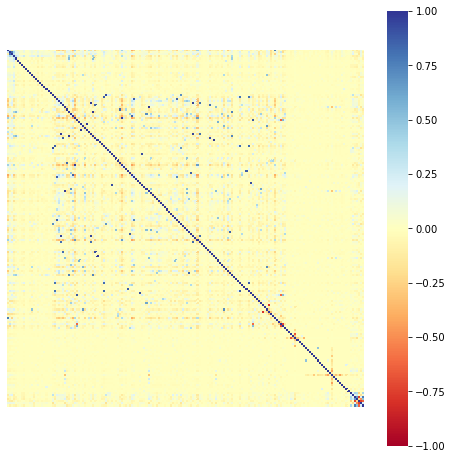

In [34]:
import seaborn as sns
from sklearn.pipeline import FeatureUnion

def correlate_features(transformers):
    trans_tuples = []
    for l, t in transformers.items():
        #feature_union.fit(X_sp)
        trans_tuples.append((l, t))
    # Create and fit feature union
    union_trans = FeatureUnion(trans_tuples)
    data = union_trans.fit_transform(X_sp, y).toarray()
    return np.corrcoef(x=data, rowvar=False), union_trans.get_feature_names()

# Compute correlation matrix
corr_matrix, labels = correlate_features(transformers)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr_matrix, xticklabels=''*len(corr_matrix), yticklabels=''*len(corr_matrix), vmin=-1, vmax=1, cmap="RdYlBu", square=True)
plt.show()

#ax = sns.heatmap(corr_matrix, xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1, cmap="RdYlBu")